In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner as kt

KeyboardInterrupt: 

In [3]:
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [4]:
df = pd.read_csv("datasets\covid19postvaxstatewidestats.csv")

df = df[df['vaccinated_cases_per_100k'].notna()]

df = df.reset_index(drop=True)

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\dangn\AppData\Local\Temp\ipykernel_16452\1779633502.py:1: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("datasets\covid19postvaxstatewidestats.csv")


In [5]:
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")

In [6]:
df_vac = df[['vaccinated_cases_per_100k', 'vaccinated_hosp_per_100k', 'vaccinated_deaths_per_100k']].values

df_vac

array([[3.80579985, 0.0920758 , 0.        ],
       [3.54603189, 0.08510477, 0.        ],
       [3.12023361, 0.07866135, 0.        ],
       ...,
       [2.93185772, 0.25012983, 0.02965966],
       [2.94219992, 0.24172308, 0.02965927],
       [2.94265341, 0.24369698, 0.0311418 ]])

In [7]:
def sequence_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i+time_step,:])
    return np.array(X), np.array(y)

In [8]:
split_index = int(len(df_vac) * 0.8)

train_vac = df_vac[:split_index]
test_vac = df_vac[split_index:]

X_train, y_train = sequence_data(train_vac, 10)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

X_test, y_test = sequence_data(test_vac, 10)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [9]:
X_train.shape

(615, 10, 3)

In [10]:
y_train.shape

(615, 3)

In [9]:
def model_builder(hp):
    model = Sequential()

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])

    hp_dense_layers = hp.Choice('num_dense_layers', [1,2])

    hp_layer_1 = hp.Int('layer_1', min_value=16, max_value=512, step=16)

    hp_layer_2 = hp.Int('layer_2', min_value=16, max_value=512, step=16)

    hp_layer_3 = hp.Int('layer_3', min_value=16, max_value=512, step=16)


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units = hp_layer_1, activation=hp_activation, input_shape = (X_train.shape[1],X_train.shape[2])))

    model.add(Dense(units = hp_layer_2, activation = hp_activation))

    if hp_dense_layers >= 2:
        model.add(Dense(units = hp_layer_3, activation = hp_activation))
    # if hp_dense_layers == 3:
    #     model.add(Dense(units = hp_layer_3, activation = hp_activation))

    model.add(Dense(units=3, activation=hp_activation))


    model.compile(optimizer = Adam(learning_rate=hp_learning_rate), loss='mse', metrics=['mae'])

    return model

In [10]:
tuner = kt.Hyperband(model_builder, 
                     objective='val_mae',
                     max_epochs=10,
                     factor = 3,
                     directory = 'dir_vac',
                     project_name = 'one')

Reloading Tuner from dir_vac\one\tuner0.json


In [13]:
stop_early = EarlyStopping(monitor = 'val_mae', patience = 5)

In [14]:
tuner.search(X_train, y_train, epochs=50, validation_data=[X_test, y_test], callbacks=[stop_early])

Trial 30 Complete [00h 00m 03s]
val_mae: 2.912584066390991

Best val_mae So Far: 0.3119761347770691
Total elapsed time: 00h 01m 20s


In [11]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

In [16]:
print("The best hyperparameters are:")
for key, value in best_hp.values.items():
    print(f"{key}: {value}")

The best hyperparameters are:
activation: relu
num_dense_layers: 1
layer_1: 320
layer_2: 240
layer_3: 368
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022


In [17]:
model = tuner.hypermodel.build(best_hp)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 320)            │       414,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 240)            │        77,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           723 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,483 (1.88 MB)

 Trainable params: 492,483 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Test performance of regularizers

def model_regularizers(hp):
    model = Sequential()

    hp_dropout = hp.Choice('dropout_rate', values=[0.0, 0.2, 0.3, 0.4, 0.5])
    hp_l2_reg = hp.Choice('l2_reg_strength', values=[0.0, 1e-2, 1e-3, 1e-4])

    model.add(LSTM(units = best_hp.get("layer_1"), activation=best_hp.get("activation"), input_shape = (X_train.shape[1],X_train.shape[2]),  kernel_regularizer=l2(hp_l2_reg)))
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(units = best_hp.get("layer_2"), activation=best_hp.get("activation"), kernel_regularizer=l2(hp_l2_reg)))
    model.add(Dropout(rate=hp_dropout))

    if best_hp.get("num_dense_layers") >= 2:
        model.add(Dense(units = best_hp.get("layer_3"), activation=best_hp.get("activation"), kernel_regularizer=l2(hp_l2_reg)))
        model.add(Dropout(rate=hp_dropout))
    # if best_hp.get("num_dense_layers") == 3:
    #     model.add(Dense(units = best_hp.get("layer_3"), activation=best_hp.get("activation"), kernel_regularizer=l2(hp_l2_reg)))
    #     model.add(Dropout(rate=hp_dropout))

    model.add(Dense(units=3, activation=best_hp.get("activation")))

    model.compile(optimizer = Adam(learning_rate=best_hp.get("learning_rate")), loss='mse', metrics=['mae'])

    return model

In [19]:
tuner = kt.Hyperband(model_regularizers, 
                     objective='val_mae',
                     max_epochs=10,
                     factor = 3,
                     directory = 'dir_vac',
                     project_name = 'second')

In [20]:
tuner.search(X_train, y_train, epochs=50, validation_data=[X_test, y_test], callbacks=[stop_early])

Trial 27 Complete [00h 00m 05s]
val_mae: 0.46137550473213196

Best val_mae So Far: 0.3726870119571686
Total elapsed time: 00h 01m 23s


In [21]:
best_hp1 = tuner.get_best_hyperparameters(num_trials=1)[0]

In [22]:
print("The best hyperparameters are:")
for key, value in best_hp1.values.items():
    print(f"{key}: {value}")

The best hyperparameters are:
dropout_rate: 0.0
l2_reg_strength: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015


In [ ]:
model_multivariate = tuner.hypermodel.build(best_hp)
model_multivariate.summary()

In [13]:
history = model_multivariate.fit(X_train, y_train, epochs = 50, validation_data = [X_test, y_test])

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 197.9487 - mae: 3.6158 - val_loss: 0.5217 - val_mae: 0.4615
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15.1538 - mae: 1.0677 - val_loss: 0.6222 - val_mae: 0.5122
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.4932 - mae: 1.1577 - val_loss: 0.4300 - val_mae: 0.4556
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 26.0541 - mae: 1.3522 - val_loss: 0.7832 - val_mae: 0.5263
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7932 - mae: 0.8243 - val_loss: 0.4300 - val_mae: 0.4006
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8455 - mae: 0.7919 - val_loss: 0.7795 - val_mae: 0.5493
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9583 - mae: 0.7068 - val_loss: 0.3636 - val_mae: 0.3783
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5898 - mae: 0.6777 - val_loss: 0.3822 - val_mae: 0.4384
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 

In [16]:
split_index = int(len(df_vac) * 0.8)

train_vac = df_vac[:split_index]
test_vac = df_vac[split_index:]

X_test, y_test = sequence_data(test_vac, 10)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


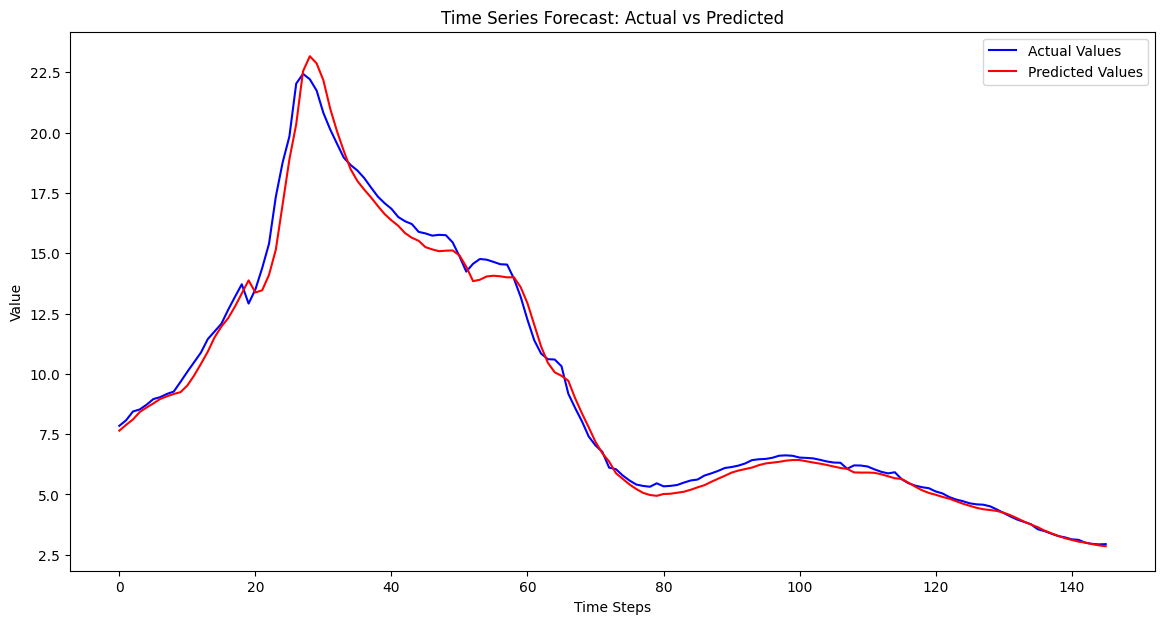

In [17]:
predictions_vac = model_multivariate.predict(X_test)

plt.figure(figsize=(14, 7))
plt.plot(y_test[:,0], label='Actual Values', color='blue')
plt.plot(predictions_vac[:,0], label='Predicted Values', color='red')
plt.title('Time Series Forecast: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
model_multivariate.save('model/LSTM_multivariate_vac.keras')